In [1]:
import os
import pandas as pd
import janitor
import numpy as np
pd.set_option('display.max_columns', 100)

import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.05, 
              style='whitegrid', palette='dark') #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from forestplot import forestplot
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings('ignore')

def save_mpl_fig(savepath):
    plt.savefig(f"{savepath}.pdf", dpi=None, bbox_inches="tight", pad_inches=0)
    plt.savefig(f"{savepath}.png", dpi=120, bbox_inches="tight", pad_inches=0)
    
DATAPATH = "../adult-data/output"        

In [2]:
# (fold cell) Retrieve porn sites from vt payloads
df_vt_categories = (
    pd
    .read_csv("../data/vt_domain_categories.csv")
    .rename_column("domain", "private_domain")
    # ===================================================
    # Get forcepoint porn 
    .assign(forcepoint_porn=lambda df_: (df_["forcepoint_threatseeker"]=='sex')|(df_["forcepoint_threatseeker"]=='adult content'))
    .assign(forcepoint_adult=lambda df_: df_["forcepoint_threatseeker"]=='adult content')
    # ===================================================
    # Get bitdefender porn 
    .assign(bitdefender_porn=lambda df_: df_["bitdefender"]=='porn')
    # ===================================================
    # Get alphamountain_ai porn 
    .assign(alphamountain_porn=lambda df_: (df_["alphamountain_ai"].str.contains('porn', case=False))|(df_["alphamountain_ai"].str.contains('adult', case=False))|(df_["alphamountain_ai"].str.contains('mature', case=False)))
)    
df_vt_categories.head()

,private_domain,forcepoint_threatseeker,xcitium_verdict_cloud,bitdefender,alphamountain_ai,sophos,comodo_valkyrie_verdict,dr_web,webroot,trendmicro,prebytes,websense_threatseeker,yandex_safebrowsing,forcepoint_porn,forcepoint_adult,bitdefender_porn,alphamountain_porn
0,007james.com,entertainment,media sharing,entertainment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,0123movie.net,NaN,media sharing,entertainment,"Piracy/Plagiarism, Video/Multimedia",video hosting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2,0410690.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
3,042jam.com,media file download,NaN,radiomusic,Entertainment,NaN,media sharing,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
4,042nobs.com,NaN,NaN,NaN,"Audio, Entertainment",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


In [3]:
# (fold cell) Load and prep web browsing data
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration", "visit_time_local"]
usecols = ["caseid", "category", "private_domain", "page_duration", "session_start_time"]

df = (pd.concat([
        # Get web_mobile
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ), 
        # Get web_desktop
        pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"),
            usecols=usecols_web_desktop,
            low_memory=False,
        ),
        # Get web
        (pd.read_csv(
            os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
            usecols=usecols,
            low_memory=False,
        )
         # Renaming columns to be consistent w/ web_mobile & web_desktop
         .rename_column("session_start_time", "visit_time_local")
         .rename_column("page_duration", "visit_duration")
        )
        ])
      # ====================================================
      # Merge to get VT categories
      .merge(df_vt_categories, on="private_domain", validate="m:1")
     )
# print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

len(df)=6,236,780


,caseid,private_domain,category,visit_time_local,visit_duration,forcepoint_threatseeker,xcitium_verdict_cloud,bitdefender,alphamountain_ai,sophos,comodo_valkyrie_verdict,dr_web,webroot,trendmicro,prebytes,websense_threatseeker,yandex_safebrowsing,forcepoint_porn,forcepoint_adult,bitdefender_porn,alphamountain_porn
0,205323077,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,search engines and portals,unknown,searchengines,NaN,search engines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,205323077,google.com,Business,2022-06-01 01:15:12,55,search engines and portals,unknown,searchengines,NaN,search engines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2,205323077,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,search engines and portals,unknown,searchengines,NaN,search engines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
3,205323077,google.com,Search Engines and Portals,2022-06-04 15:40:42,36,search engines and portals,unknown,searchengines,NaN,search engines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
4,205323077,google.com,Search Engines and Portals,2022-06-06 17:36:10,98,search engines and portals,unknown,searchengines,NaN,search engines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False


## Forcepoint

In [4]:
# (fold cell) Get adult sites metrics
df_forcepoint_count = (df
                       .query("forcepoint_porn")
                       .dropna(subset=["caseid", "forcepoint_threatseeker", "visit_duration"])
                       .groupby(["private_domain", "forcepoint_threatseeker"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "forcepoint_threatseeker"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "forcepoint_threatseeker"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(forcepoint_threatseeker=lambda df: df.forcepoint_threatseeker.str.title())
                       .assign(forcepoint_threatseeker=lambda df: df.forcepoint_threatseeker.apply(lambda x: x.rjust(46) if len(x)<46 else x))
                      )
df_forcepoint_count.head()

,private_domain,forcepoint_threatseeker,count,visit_duration,ll,hl,count_str,visit_duration_str
0,xvideos.com,Sex,9372,314,9372,9372,"9,372",314
1,pornhub.com,Sex,7814,184,7814,7814,"7,814",184
2,xnxx.com,Sex,6549,207,6549,6549,"6,549",207
3,onlyfans.com,Adult Content,5805,53,5805,5805,"5,805",53
4,rule34.xxx,Sex,5797,35,5797,5797,"5,797",35


In [5]:
print((df_forcepoint_count
 .head(30)
 .filter(["private_domain", "category", "count", "visit_duration"])
 .to_markdown()
#  .to_csv("../data/top100_adultsites.csv", index=False)
))

|    | private_domain      |   count |   visit_duration |
|---:|:--------------------|--------:|-----------------:|
|  0 | xvideos.com         |    9372 |              314 |
|  1 | pornhub.com         |    7814 |              184 |
|  2 | xnxx.com            |    6549 |              207 |
|  3 | onlyfans.com        |    5805 |               53 |
|  4 | rule34.xxx          |    5797 |               35 |
|  5 | 4channel.org        |    5714 |               37 |
|  6 | fetlife.com         |    3764 |               11 |
|  7 | xhamster.com        |    3604 |              108 |
|  8 | chaturbate.com      |    2802 |               23 |
|  9 | myfreecams.com      |    2565 |               24 |
| 10 | motherless.com      |    2507 |               29 |
| 11 | literotica.com      |    2312 |               47 |
| 12 | donmai.us           |    1685 |                6 |
| 13 | hentaifox.com       |    1468 |                5 |
| 14 | sniffies.com        |    1388 |               18 |
| 15 | f95zone

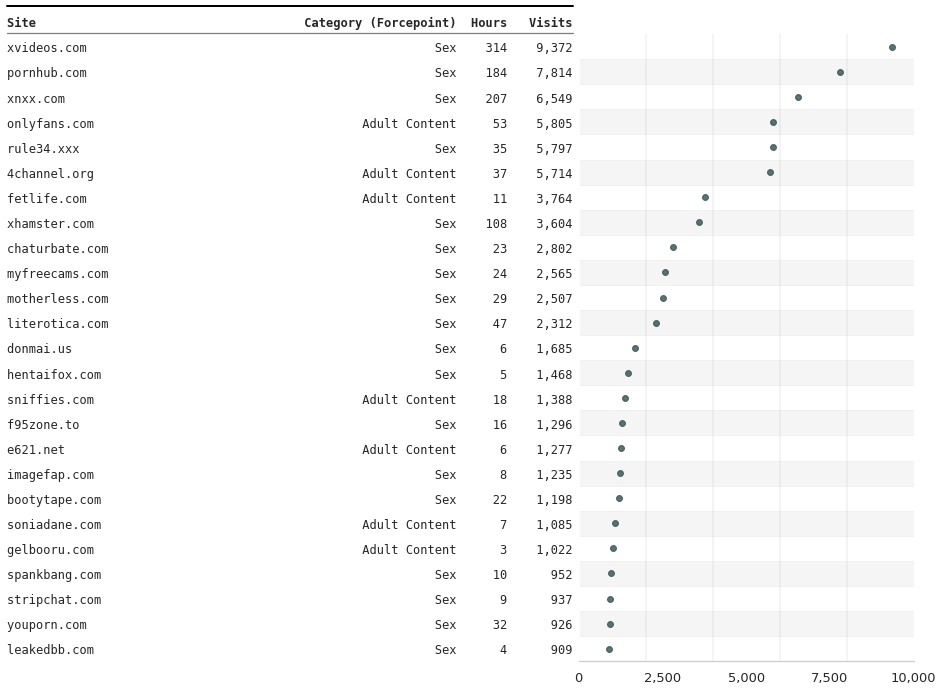

In [6]:
# Plot (fold cell)
ax = forestplot(df_forcepoint_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["forcepoint_threatseeker", "visit_duration_str", "count_str"],
                annoteheaders=[25*" " + "Category (Forcepoint)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,12_500,2_500),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
save_mpl_fig(os.path.join("../figs/top_25_adultsites_forcepoint_threatseeker"))

## Bitdefender

In [7]:
# (fold cell) Get adult sites metrics
df_bitdefender_count = (df
                       .query("bitdefender_porn")
                       .dropna(subset=["caseid", "bitdefender", "visit_duration"])
                       .groupby(["private_domain", "bitdefender"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "bitdefender"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "bitdefender"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(bitdefender=lambda df: df.bitdefender.str.title())
                        .assign(bitdefender=lambda df_: np.where(df_["bitdefender"]=="Porn", "Pornography",df_["bitdefender"]))
                       .assign(bitdefender=lambda df: df.bitdefender.apply(lambda x: x.rjust(46) if len(x)<46 else x))
                      )
df_bitdefender_count.head()

,private_domain,bitdefender,count,visit_duration,ll,hl,count_str,visit_duration_str
0,xvideos.com,Pornography,9372,314,9372,9372,"9,372",314
1,pornhub.com,Pornography,7814,184,7814,7814,"7,814",184
2,xnxx.com,Pornography,6549,207,6549,6549,"6,549",207
3,onlyfans.com,Pornography,5805,53,5805,5805,"5,805",53
4,rule34.xxx,Pornography,5797,35,5797,5797,"5,797",35


In [8]:
print((df_bitdefender_count
 .head(30)
 .filter(["private_domain", "category", "count", "visit_duration"])
 .to_markdown()
#  .to_csv("../data/top100_adultsites.csv", index=False)
))

|    | private_domain    |   count |   visit_duration |
|---:|:------------------|--------:|-----------------:|
|  0 | xvideos.com       |    9372 |              314 |
|  1 | pornhub.com       |    7814 |              184 |
|  2 | xnxx.com          |    6549 |              207 |
|  3 | onlyfans.com      |    5805 |               53 |
|  4 | rule34.xxx        |    5797 |               35 |
|  5 | xhamster.com      |    3604 |              108 |
|  6 | chaturbate.com    |    2802 |               23 |
|  7 | myfreecams.com    |    2565 |               24 |
|  8 | motherless.com    |    2507 |               29 |
|  9 | literotica.com    |    2312 |               47 |
| 10 | hentaifox.com     |    1468 |                5 |
| 11 | imagefap.com      |    1235 |                8 |
| 12 | soniadane.com     |    1085 |                7 |
| 13 | gelbooru.com      |    1022 |                3 |
| 14 | spankbang.com     |     952 |               10 |
| 15 | stripchat.com     |     937 |            

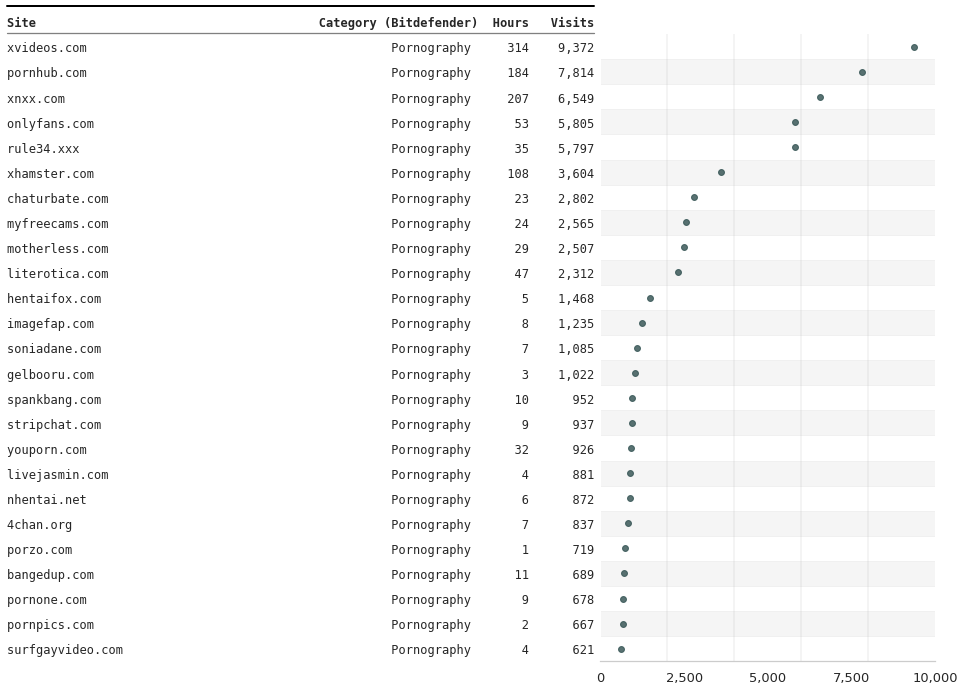

In [9]:
# Plot (fold cell)
ax = forestplot(df_bitdefender_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["bitdefender", "visit_duration_str", "count_str"],
                annoteheaders=[25*" " + "Category (Bitdefender)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,12_500,2_500),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
save_mpl_fig(os.path.join("../figs/top_25_adultsites_bitdefender"))

## Alphamountain AI

In [10]:
# (fold cell) Get adult sites metrics
df_alpha_count = (df
                       .query("alphamountain_porn")
                       .dropna(subset=["caseid", "alphamountain_ai", "visit_duration"])
                       .groupby(["private_domain", "alphamountain_ai"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "alphamountain_ai"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "alphamountain_ai"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(alphamountain_ai=lambda df: df.alphamountain_ai.str.title())
                        .assign(alphamountain_ai=lambda df: np.where(df["alphamountain_ai"]=="Arts/Culture, Mixed Content/Potentially Adult, Social Networking", ".., Mixed Content/Potentially Adult..", df["alphamountain_ai"]))
                        .assign(alphamountain_ai=lambda df: np.where(df["alphamountain_ai"]=="Mixed Content/Potentially Adult, Video/Multimedia", "Mixed Content/Potentially Adult..", df["alphamountain_ai"]))
#                         .assign(alphamountain_ai=lambda df: np.where(df["alphamountain_ai"]=="Adult/Mature, Pornography, Social Networking", "Adult/Mature, Pornography..", df["alphamountain_ai"]))
                       .assign(alphamountain_ai=lambda df: df.alphamountain_ai.apply(lambda x: x.rjust(46) if len(x)<46 else x))
                      )
df_alpha_count.head()

,private_domain,alphamountain_ai,count,visit_duration,ll,hl,count_str,visit_duration_str
0,xvideos.com,Pornography,9372,314,9372,9372,"9,372",314
1,pornhub.com,Pornography,7814,184,7814,7814,"7,814",184
2,xnxx.com,Pornography,6549,207,6549,6549,"6,549",207
3,onlyfans.com,"Adult/Mature, Pornography, Social Networking",5805,53,5805,5805,"5,805",53
4,rule34.xxx,Pornography,5797,35,5797,5797,"5,797",35


In [11]:
print((df_alpha_count
 .head(30)
 .filter(["private_domain", "alphamountain_ai", "count", "visit_duration"])
 .to_markdown()
#  .to_csv("../data/top100_adultsites.csv", index=False)
))

|    | private_domain   | alphamountain_ai                             |   count |   visit_duration |
|---:|:-----------------|:---------------------------------------------|--------:|-----------------:|
|  0 | xvideos.com      | Pornography                                  |    9372 |              314 |
|  1 | pornhub.com      | Pornography                                  |    7814 |              184 |
|  2 | xnxx.com         | Pornography                                  |    6549 |              207 |
|  3 | onlyfans.com     | Adult/Mature, Pornography, Social Networking |    5805 |               53 |
|  4 | rule34.xxx       | Pornography                                  |    5797 |               35 |
|  5 | 4channel.org     | Adult/Mature, Forums                         |    5714 |               37 |
|  6 | fetlife.com      | Adult/Mature, Pornography                    |    3764 |               11 |
|  7 | xhamster.com     | Pornography                                  |    3604 |

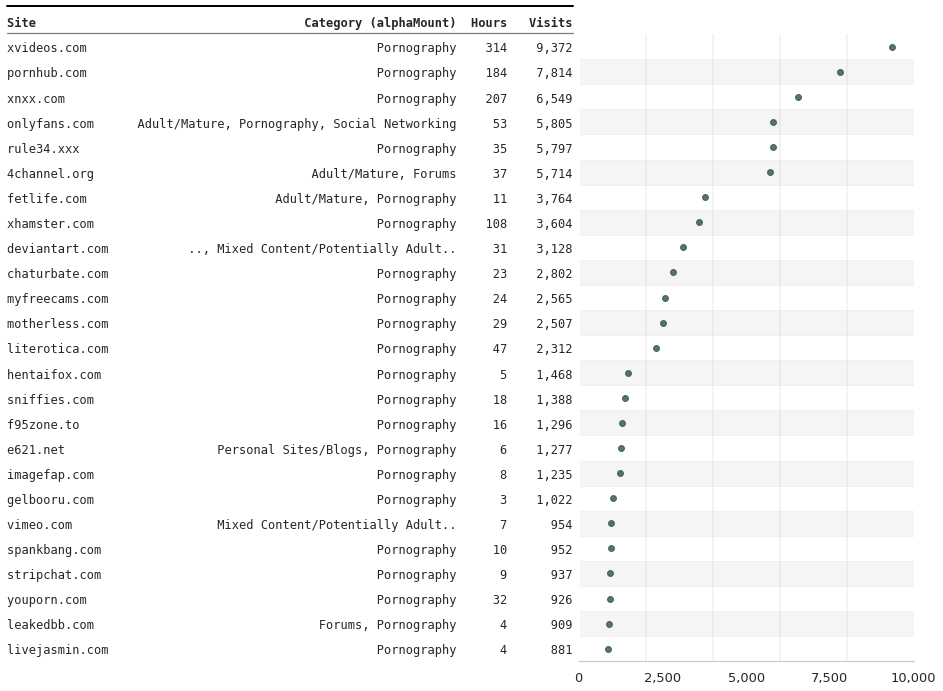

In [12]:
# Plot (fold cell)
ax = forestplot(df_alpha_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["alphamountain_ai", "visit_duration_str", "count_str"],
                annoteheaders=[25*" " + "Category (alphaMount)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,12_500,2_500),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
save_mpl_fig(os.path.join("../figs/top_25_adultsites_alphamountain"))

## Piedomains

In [13]:
# (fold cell) Retrieve porn sites from piedomains classification
pornsites = (pd
             .read_csv("../data/piedomains_classification.csv.gz")
             .query("pred_label=='porn'")
             .query("label_prob>=0.033")
             .private_domain.unique()
            )
print(len(pornsites))
print(pornsites[:20])

898
['xvideos.com' 'pornhub.com' 'fetlife.com' 'xhamster.com' 'chaturbate.com'
 'motherless.com' 'donmai.us' 'hentaifox.com' 'imagefap.com'
 'bootytape.com' 'spankbang.com' 'youporn.com' 'porzo.com' 'bangedup.com'
 'pornone.com' 'pornpics.com' 'faphouse.com' 'surfgayvideo.com'
 'rentmen.eu' 'mangaowl.to']


In [14]:
# (fold cell) Get adult sites metrics
df_piedomains_count = (df
                       .query("private_domain in @pornsites")
                       .dropna(subset=["caseid", "bitdefender", "visit_duration"])
                       .groupby(["private_domain", "bitdefender"])
                       .size()
                       .reset_index()
                       .rename_column(0, "count")
                       .sort_values("count", ascending=False, ignore_index=True)
                       # Get total visit duration of websites
                       .merge((df
                               .groupby(["private_domain", "bitdefender"])
                               .visit_duration.sum()
                               .reset_index()
                               # Normalize from second(s) to hour(s)
                               .assign(visit_duration=lambda df: df.visit_duration/3600)
                               .round(decimals=0)
                               .assign(visit_duration=lambda df: df.visit_duration.apply(int))
                              ), how="left", on=["private_domain", "bitdefender"], validate="1:1"
                             )                       
                       # Preparing for plot
                       .assign(ll=lambda df: df["count"])
                       .assign(hl=lambda df: df["count"])
                       # Format count and visit_duration
                       .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x['count']), axis=1))
                       .assign(count_str=lambda df: df.count_str.apply(lambda x: x.rjust(7) if len(x)<7 else x))
                       .assign(visit_duration_str=lambda df: df.apply(lambda x: "{:,}".format(x['visit_duration']), axis=1))
                       .assign(visit_duration_str=lambda df: df.visit_duration_str.apply(lambda x: x.rjust(5) if len(x)<5 else x))
                       .assign(cat=lambda df: "Pornography")
                       .assign(cat=lambda df: df.cat.apply(lambda x: x.rjust(46) if len(x)<46 else x))
                      )
df_piedomains_count.head()

,private_domain,bitdefender,count,visit_duration,ll,hl,count_str,visit_duration_str,cat
0,xvideos.com,porn,9372,314,9372,9372,"9,372",314,Pornography
1,pornhub.com,porn,7814,184,7814,7814,"7,814",184,Pornography
2,fetlife.com,sexualcontent,3764,11,3764,3764,"3,764",11,Pornography
3,xhamster.com,porn,3604,108,3604,3604,"3,604",108,Pornography
4,chaturbate.com,porn,2802,23,2802,2802,"2,802",23,Pornography


In [15]:
print((df_piedomains_count
 .head(30)
 .filter(["private_domain", "count", "visit_duration"])
 .to_markdown()
#  .to_csv("../data/top100_adultsites.csv", index=False)
))

|    | private_domain        |   count |   visit_duration |
|---:|:----------------------|--------:|-----------------:|
|  0 | xvideos.com           |    9372 |              314 |
|  1 | pornhub.com           |    7814 |              184 |
|  2 | fetlife.com           |    3764 |               11 |
|  3 | xhamster.com          |    3604 |              108 |
|  4 | chaturbate.com        |    2802 |               23 |
|  5 | motherless.com        |    2507 |               29 |
|  6 | donmai.us             |    1685 |                6 |
|  7 | hentaifox.com         |    1468 |                5 |
|  8 | imagefap.com          |    1235 |                8 |
|  9 | bootytape.com         |    1198 |               22 |
| 10 | spankbang.com         |     952 |               10 |
| 11 | youporn.com           |     926 |               32 |
| 12 | porzo.com             |     719 |                1 |
| 13 | bangedup.com          |     689 |               11 |
| 14 | pornone.com           |     678 |

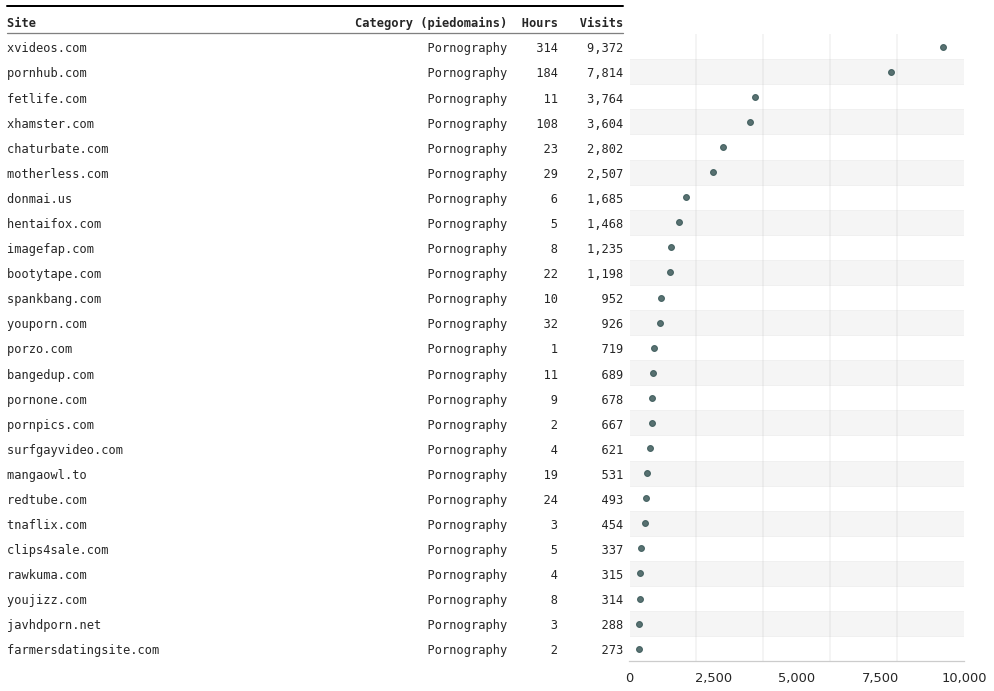

In [16]:
# Plot (fold cell)
ax = forestplot(df_piedomains_count.head(25), 
                estimate="count", 
                ll="ll", hl="hl",
                varlabel="private_domain",
                annote=["cat", "visit_duration_str", "count_str"],
                annoteheaders=[25*" " + "Category (piedomains)", "Hours", " Visits"],
                ci_report=False,
                figsize=(6,12),
                color_alt_rows=True,
                xticks=range(0,12_500,2_500),  # x-ticks to be printed
                table=True,
               **{"marker": "o",  # set maker symbol as diamond
                  "variable_header": "Site",
                  "markersize": 35,  # adjust marker size
#                   "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                  "xlinecolor": "1",  # gray color for x-reference line
                  "xtick_size": 13,  # adjust x-ticker fontsize
                 }   
               )
ax.xaxis.set_ticks_position('none') 
ax.grid(False)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
ax.set_ylim(-.5, 25.5) # Gets rid of white padding above
for vline in [2000, 4000, 6000, 8000]:
    ax.vlines(vline, ymin=-.5, ymax=24.5, colors=".6", linewidth=.2)
save_mpl_fig(os.path.join("../figs/top_25_adultsites_piedomains"))